In [1]:
import sqlalchemy
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import dbconfig as db

In [2]:
engine = sqlalchemy.engine_from_config(db.config, prefix='db.')

# Is there example-to-example leakage?

Let's check if the same circuits appear in multiple examples: this would be an indication of leakage that we should filter out. 

In [3]:
query_num_circuits = """SELECT circuit, count(distinct exampleid) 
     FROM raw.frontpage_traces
     GROUP BY circuit"""
df = pd.read_sql(query_num_circuits, engine)

In [4]:
df['count'].value_counts()

1    1531
Name: count, dtype: int64

So there is only one distinct example id for each circuit. Based on this, there does not appear to be circuit-to-circuit leakage - at least in the ~200 examples I have collected thus far. 

Note we could do this all in SQL using a subquery:

In [5]:
query_get_leaks = """SELECT * FROM 
    (SELECT circuit, count(distinct exampleid) 
     FROM raw.frontpage_traces
     GROUP BY circuit) leak
WHERE leak.count > 1;"""

In [6]:
df = pd.read_sql(query_get_leaks, engine)

In [7]:
df

,circuit,count


Empty! Meaning there are no rows where the count of the subquery above is greater than 1. This is a good thing. Once we get an entire dataset, this is something that we should definitely check again. The reason we care about this is because leakage from one example to another will add noise in our training data. We want our classifier to get nice, clean, and simple examples. 

# Are there examples with more than 1 rendezvous circuit? 

Let's look through our examples to see if there are examples with more than 1 rendezvous circuit. If this does happen, we should understand why. 

In [8]:
query_multiple_rend = """SELECT * FROM 
  (SELECT exampleid, count(exampleid) FROM raw.frontpage_traces
   WHERE command LIKE 'RENDEZVOUS_ESTABLISHED%%'
   GROUP BY exampleid) multiplerendezvous
WHERE multiplerendezvous.count > 1"""
df = pd.read_sql(query_multiple_rend, engine)

In [9]:
df

,exampleid,count
0,664,3
1,766,4
2,627,2
3,663,2
4,729,2
5,650,3
6,778,3
7,736,3
8,757,2
9,682,2


Curious - let's dig into what is occurring here by inspecting a single row. We already know that it is not leakage from other examples because we already checked that above. 

Let's get all the cells for `exampleid=612` since it appears to have 5 rendezvous circuits. 

In [10]:
query_multiple_rend = """SELECT * FROM raw.frontpage_traces
WHERE exampleid=612
ORDER BY t_trace;"""
df = pd.read_sql(query_multiple_rend, engine)

In [11]:
df

,cellid,exampleid,ingoing,circuit,stream,command,length,t_trace
0,263177,612,False,2536592101,0,EXTEND2(14),119,1.466926e+09
1,263178,612,False,3278330302,0,EXTEND2(14),119,1.466926e+09
2,263179,612,False,3793350858,0,EXTEND2(14),119,1.466926e+09
3,263180,612,True,2536592101,0,EXTENDED2(15),66,1.466926e+09
4,263181,612,False,2536592101,0,EXTEND2(14),119,1.466926e+09
5,263182,612,True,3278330302,0,EXTENDED2(15),66,1.466926e+09
6,263183,612,False,3278330302,0,EXTEND2(14),119,1.466926e+09
7,263184,612,True,3793350858,0,EXTENDED2(15),66,1.466926e+09
8,263185,612,False,3793350858,0,EXTEND2(14),119,1.466926e+09
9,263186,612,True,3278330302,0,EXTENDED2(15),66,1.466926e+09


Alright... let's just quickly visualize what exactly is occuring here. Fortunately, we have a nice routine for making plots of Tor traces #swag.

In [12]:
from trace_plot import create_single, create_by_circuit

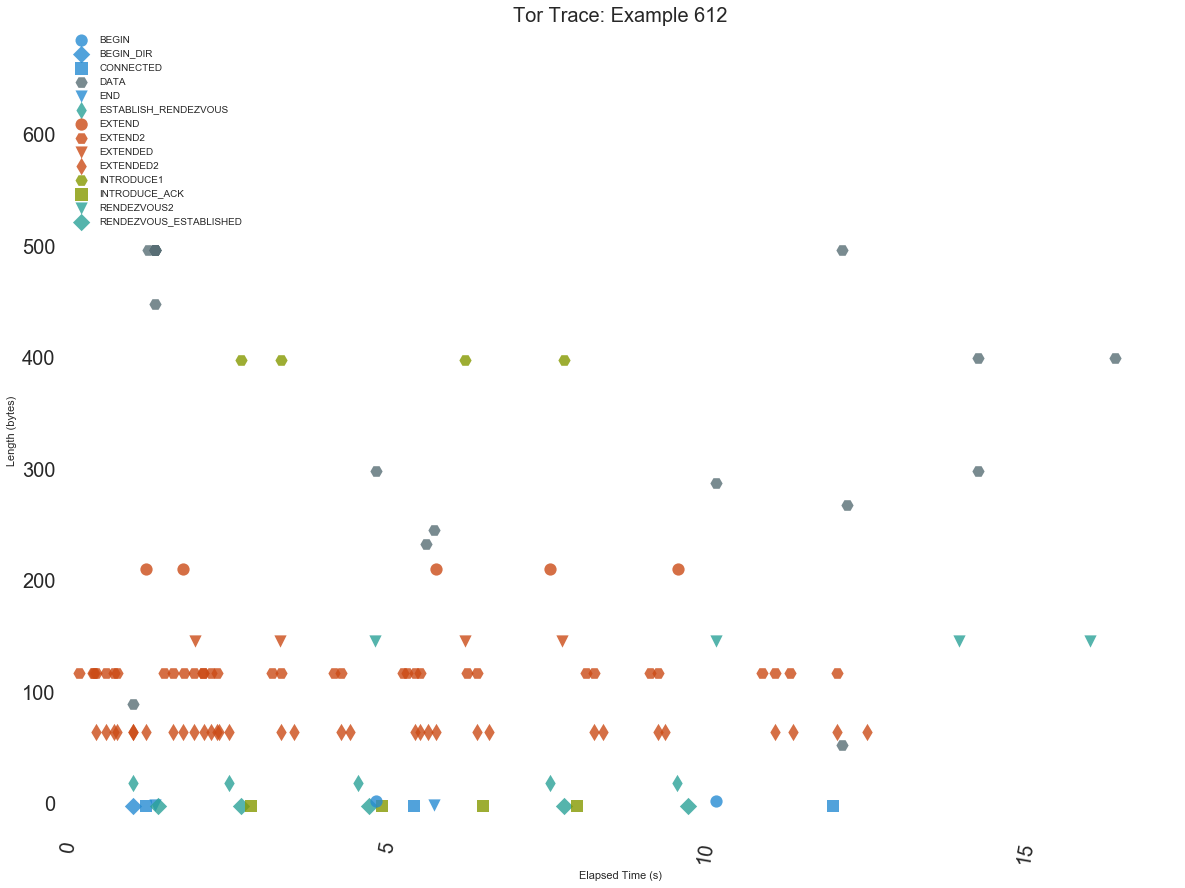

In [6]:
create_single(df, titlestr="Tor Trace: Example 612")

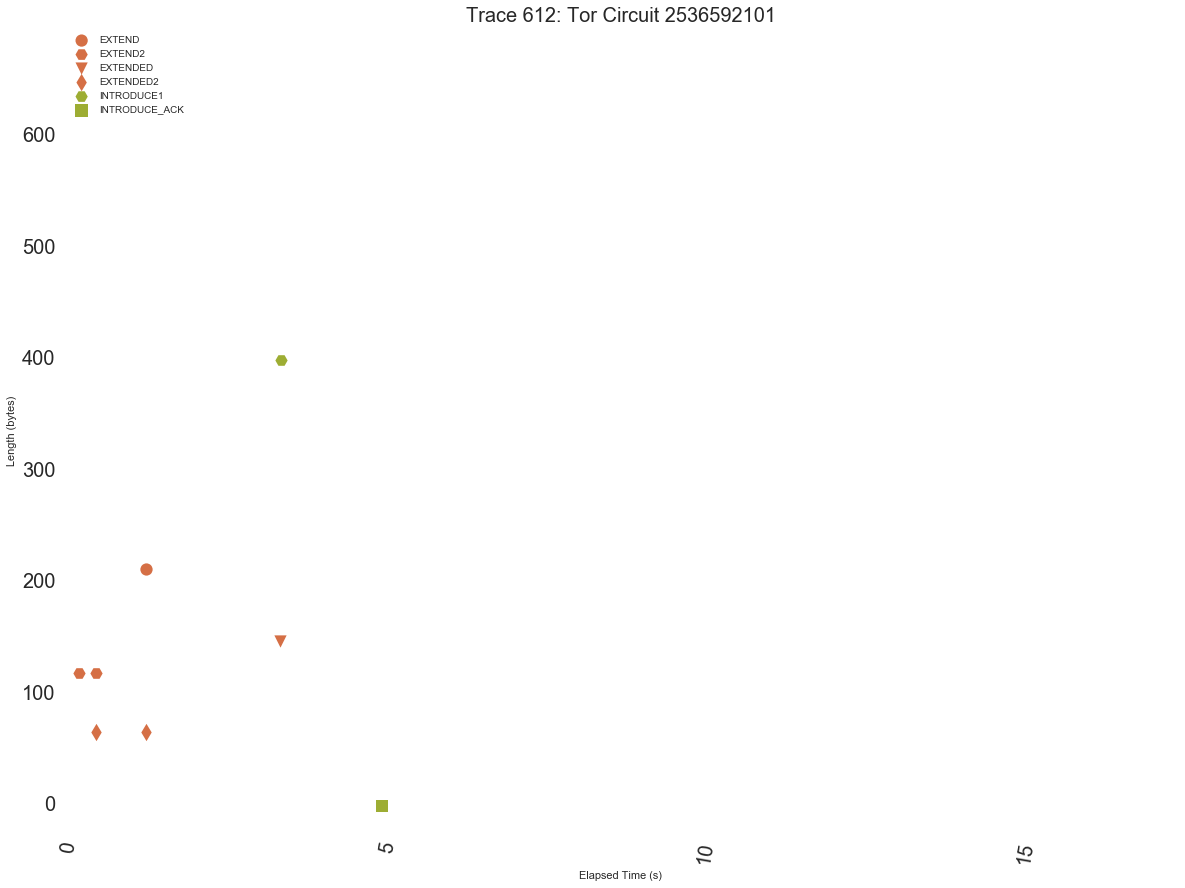

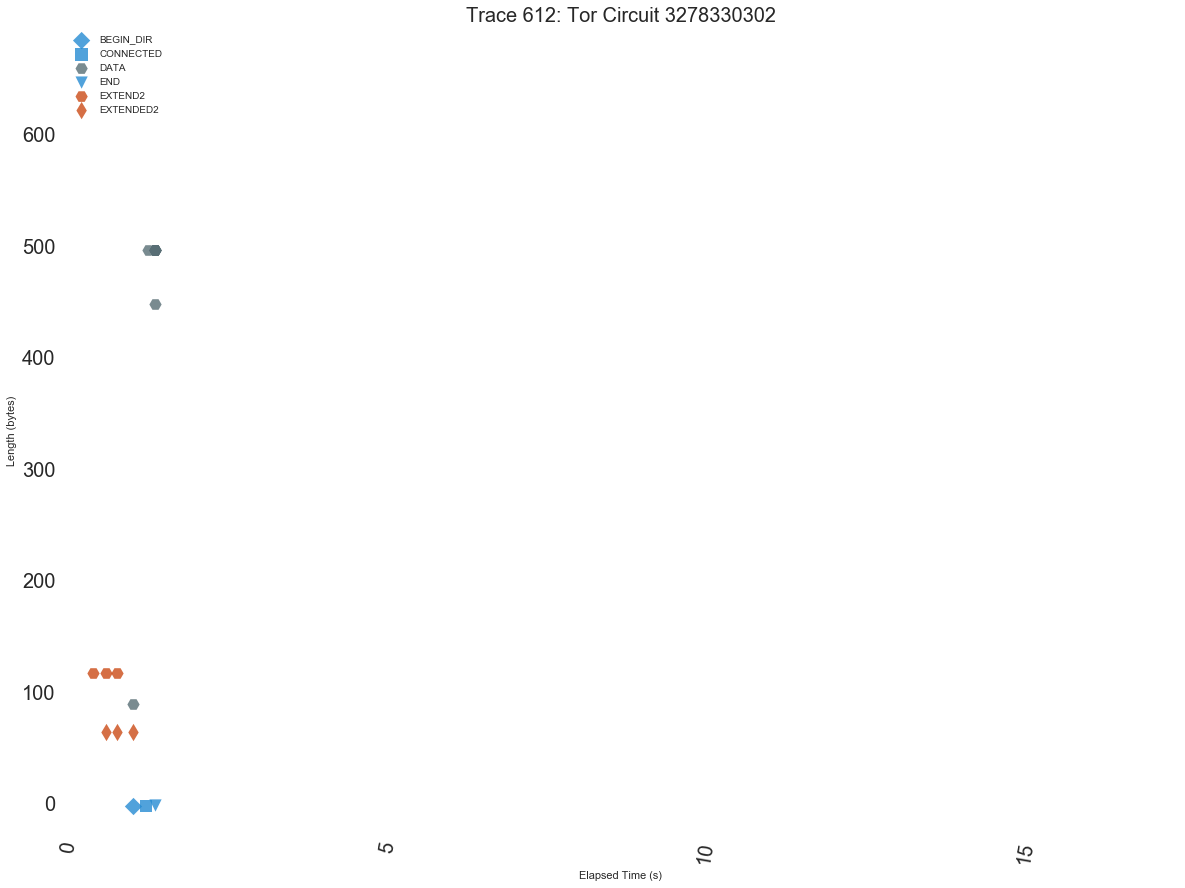

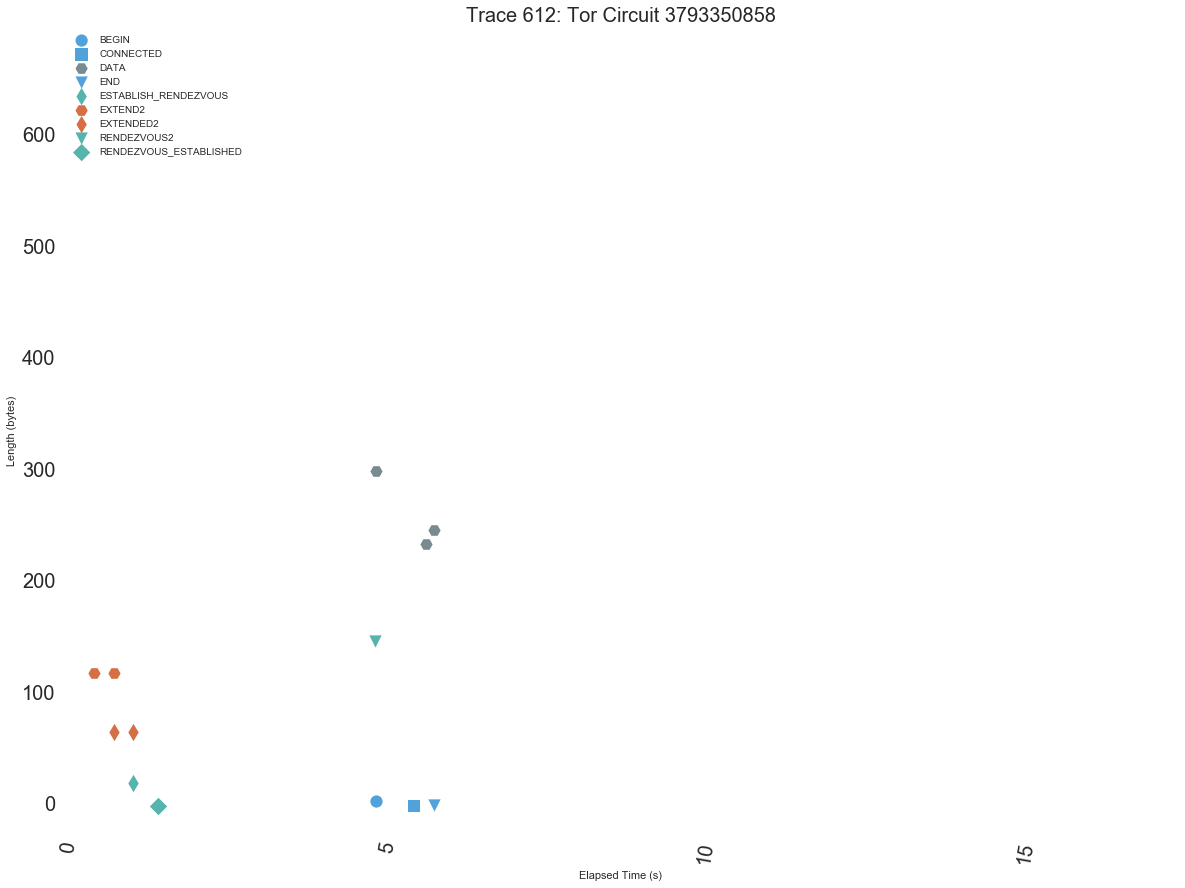

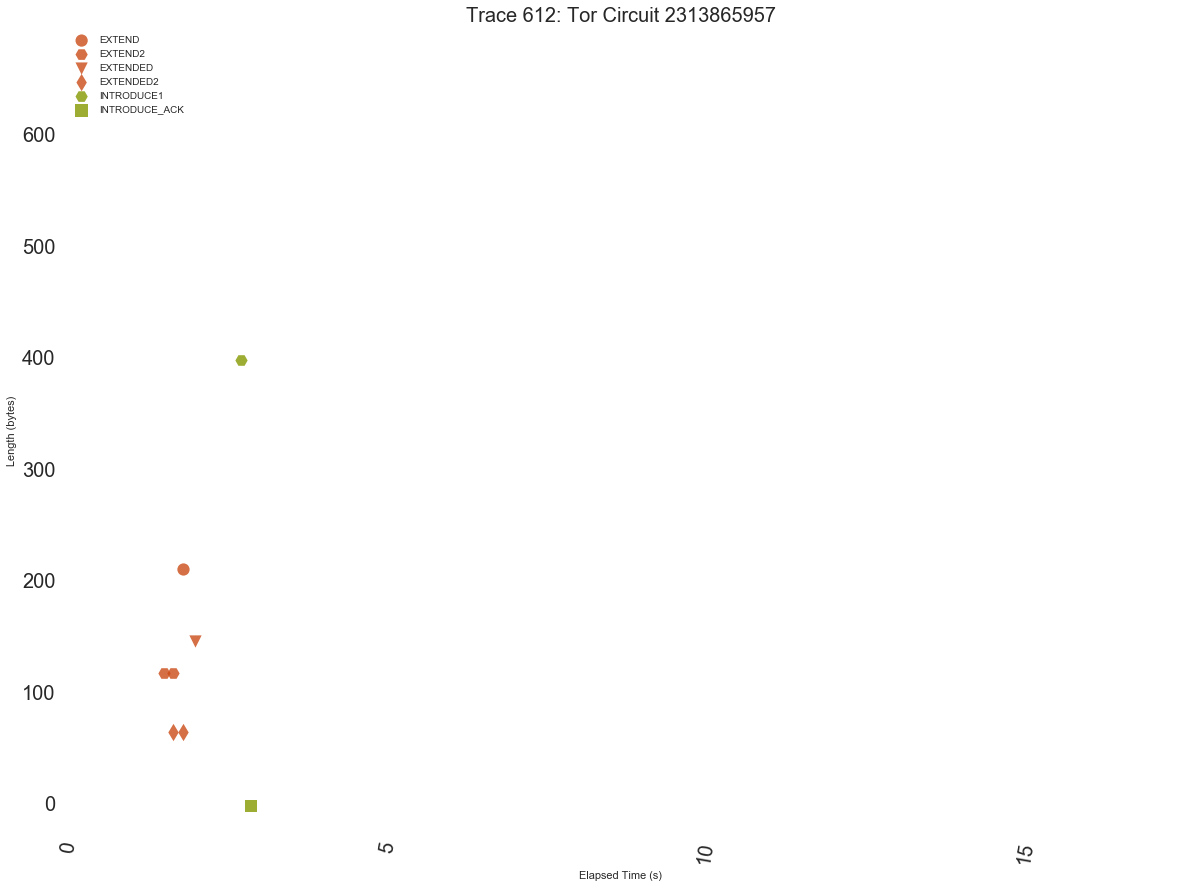

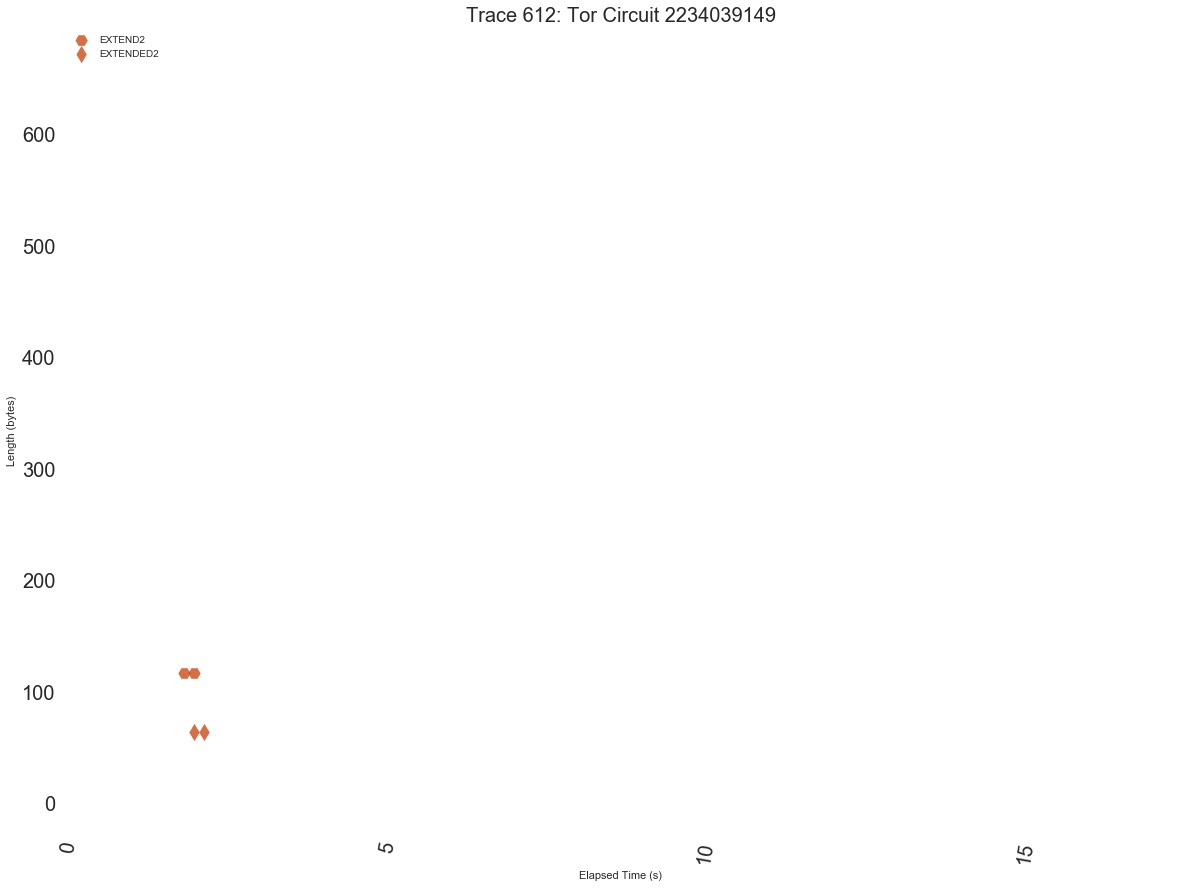

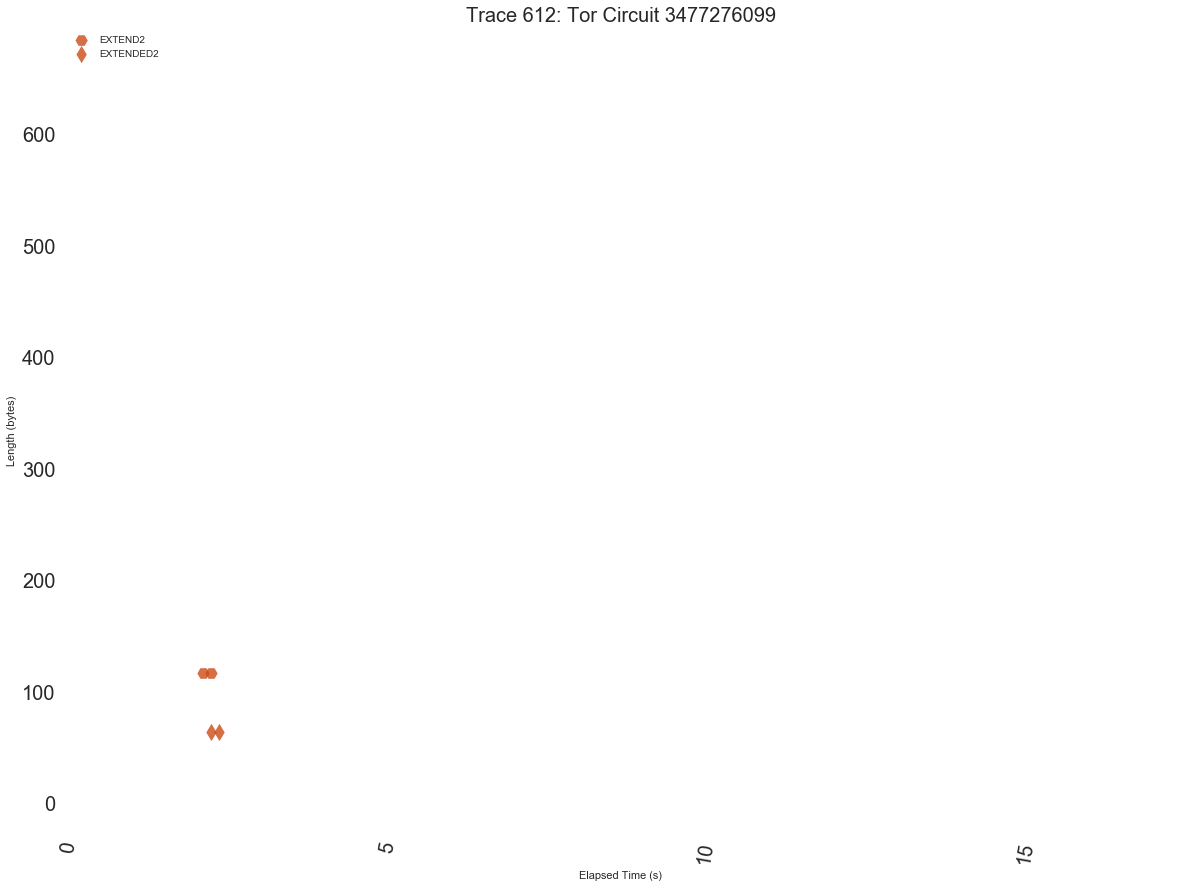

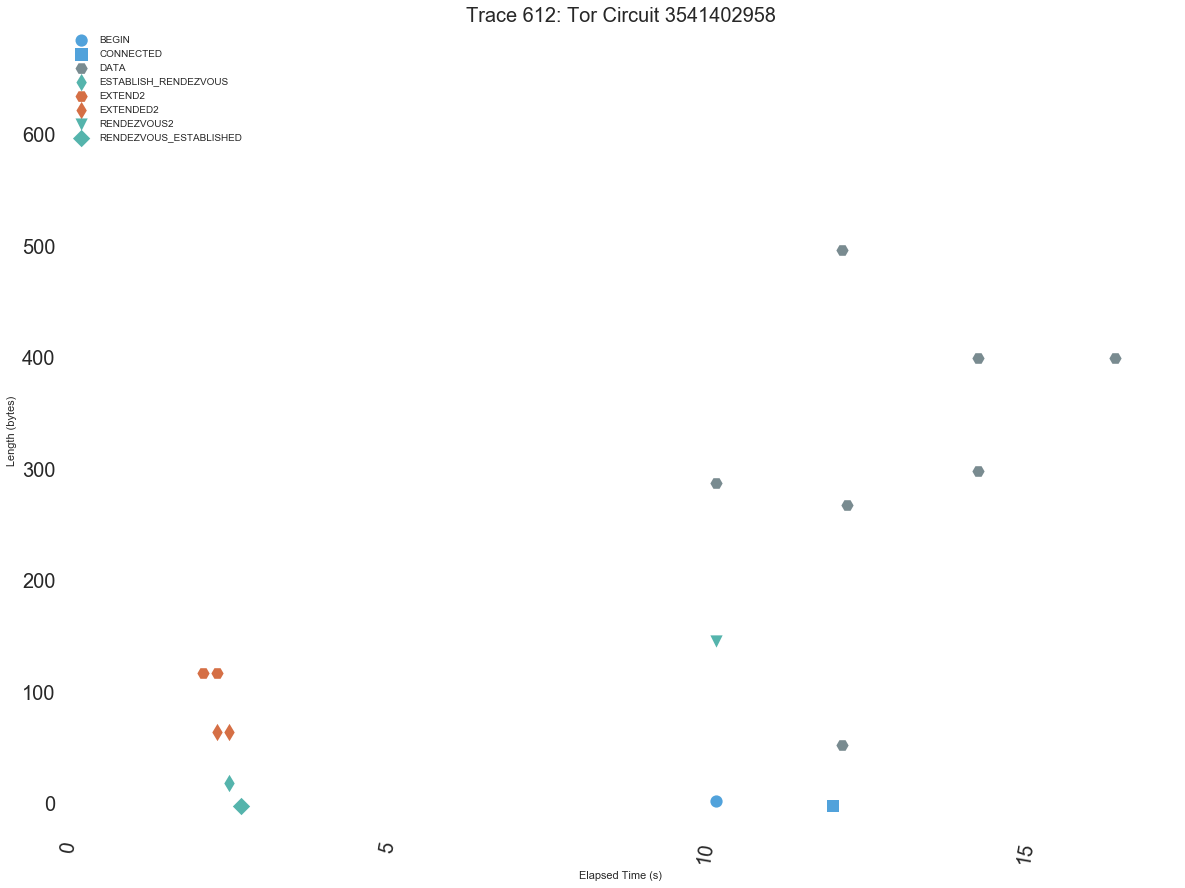

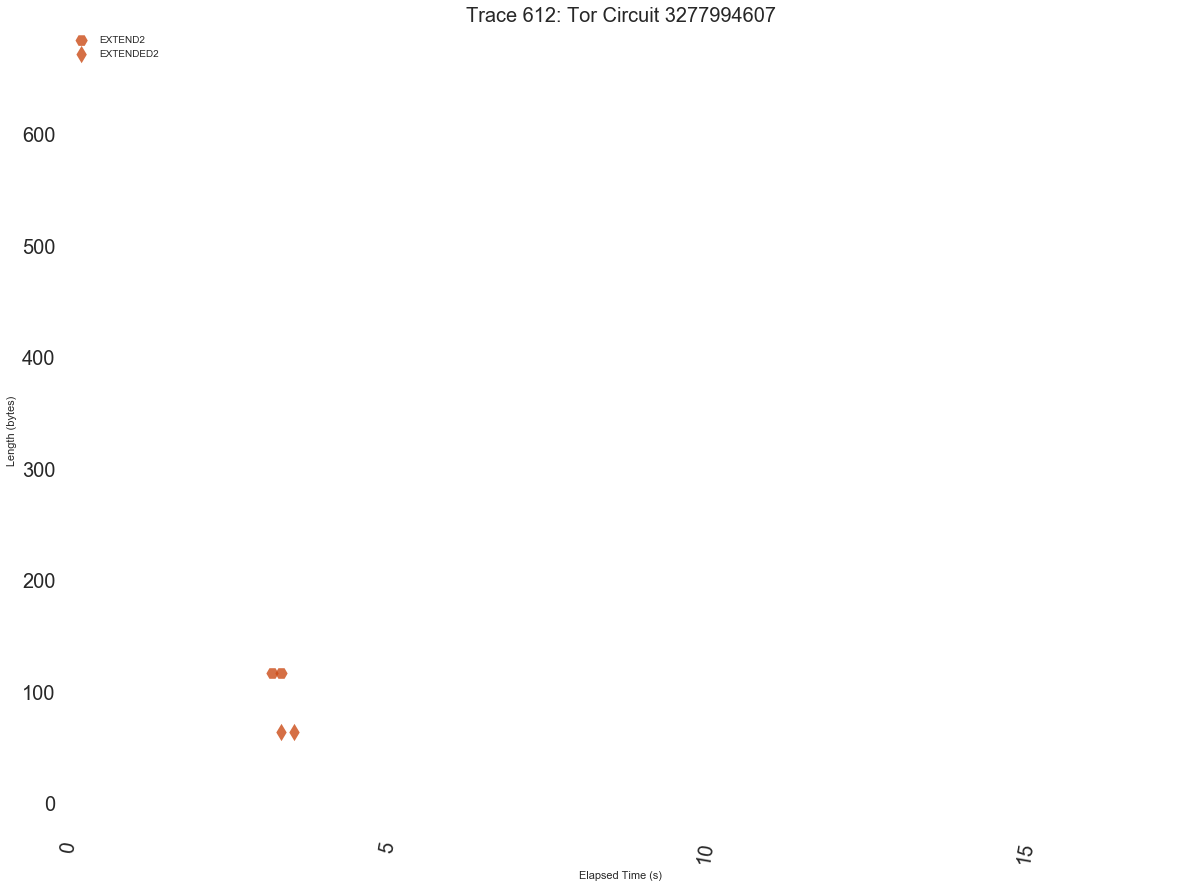

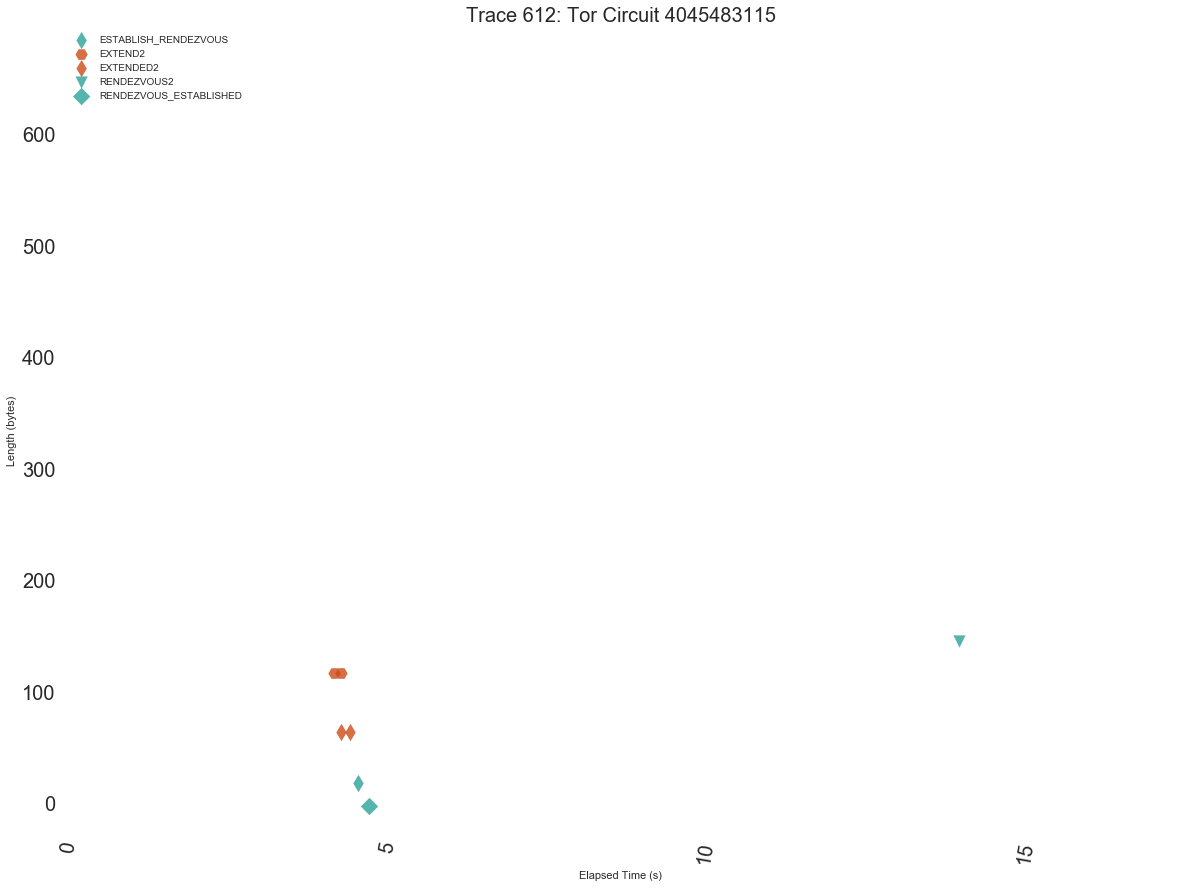

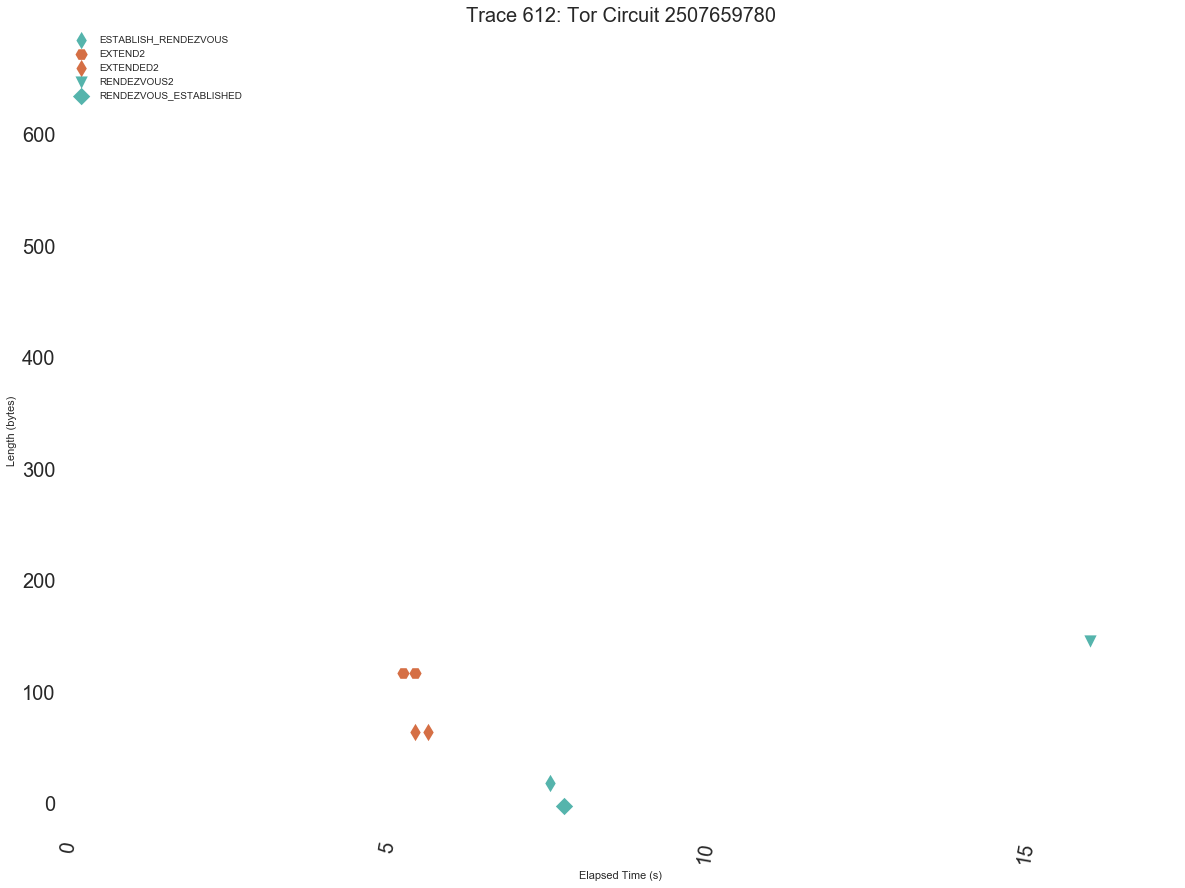

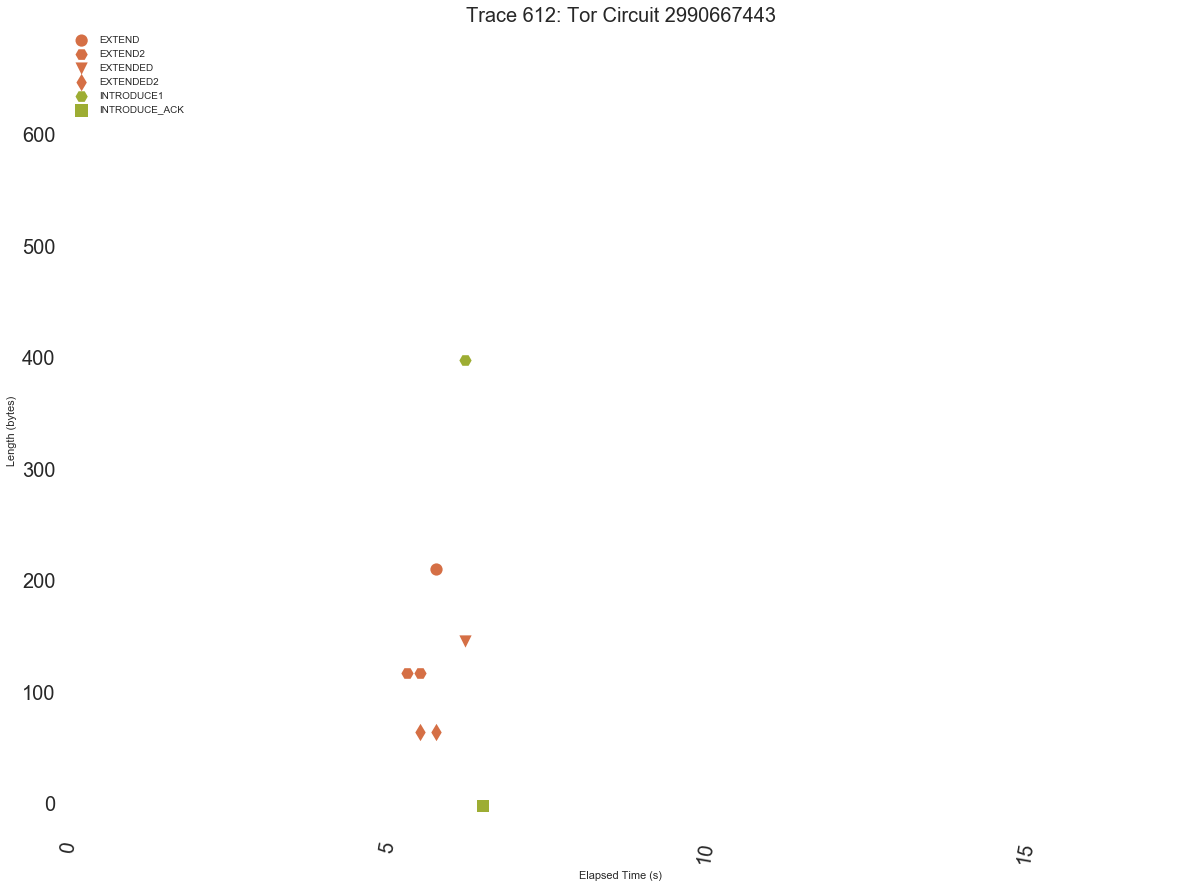

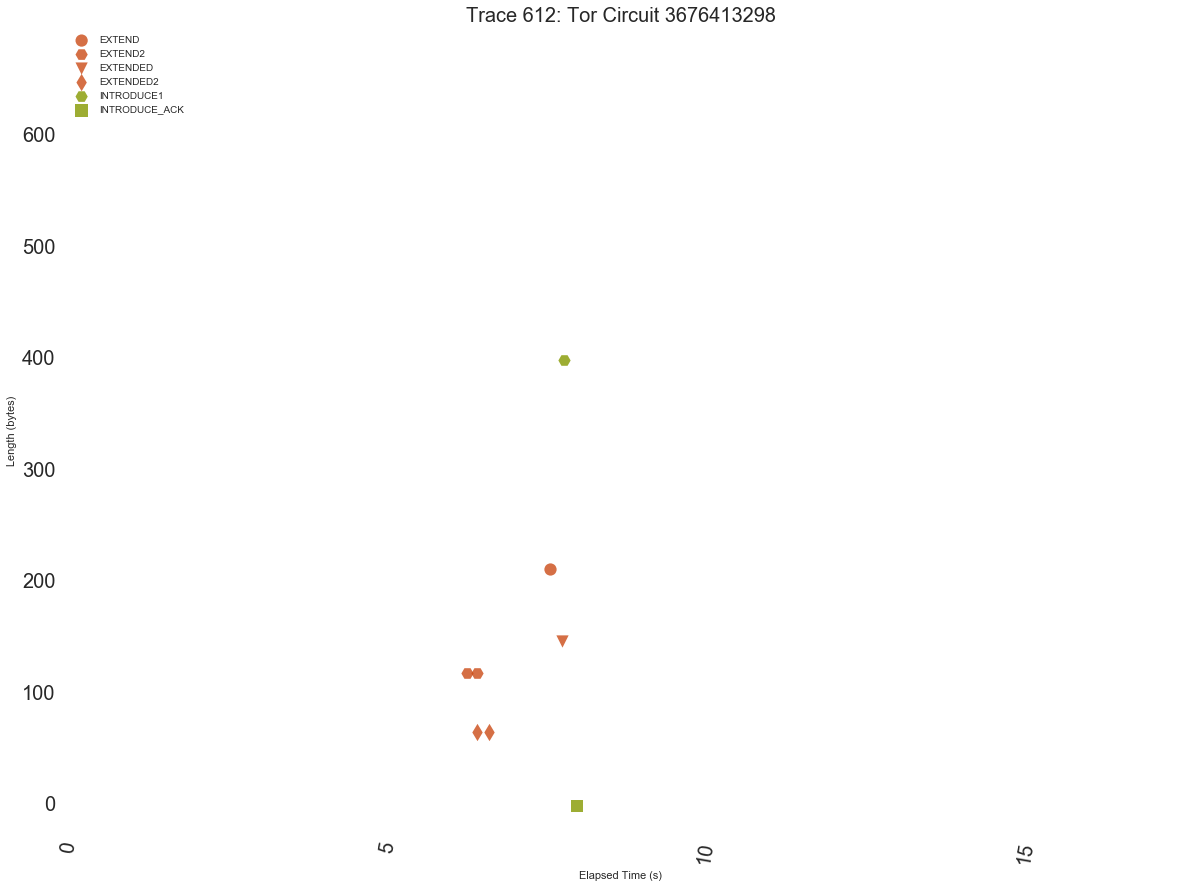

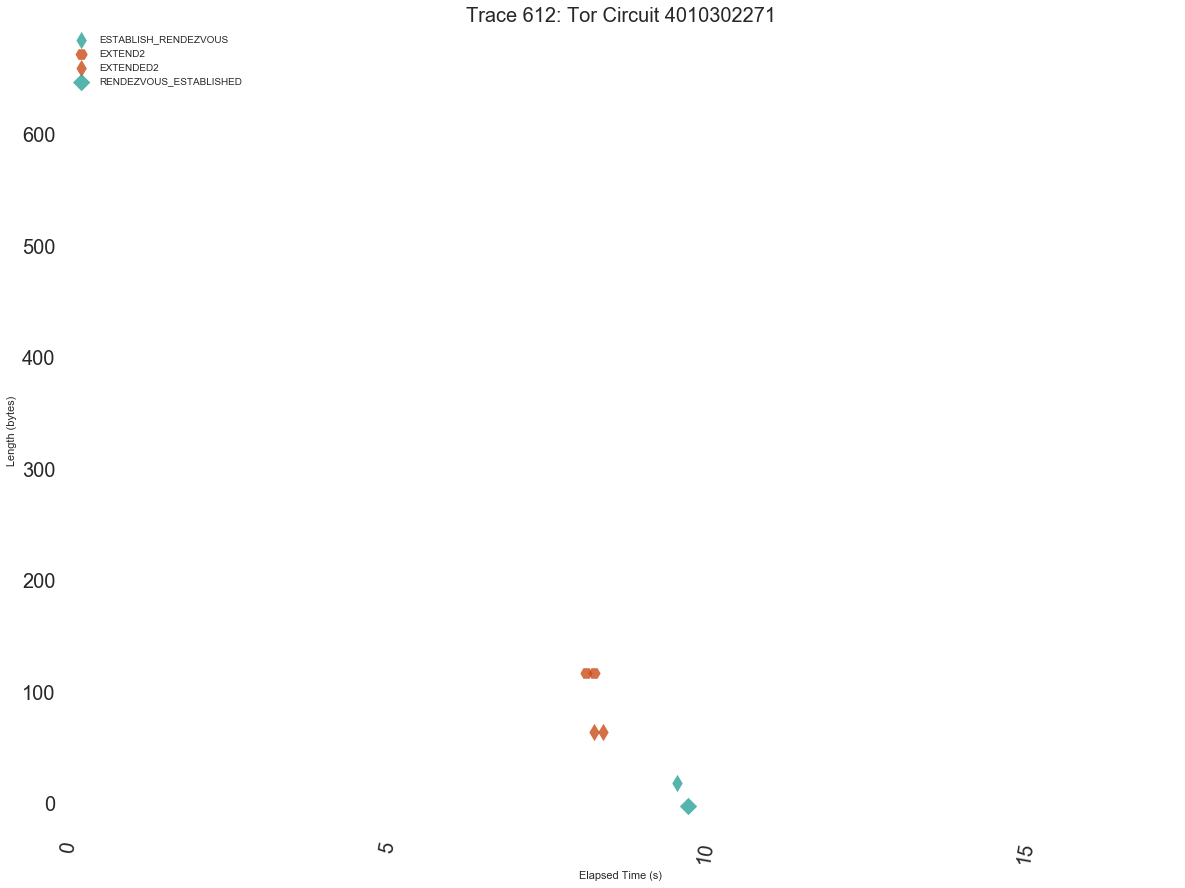

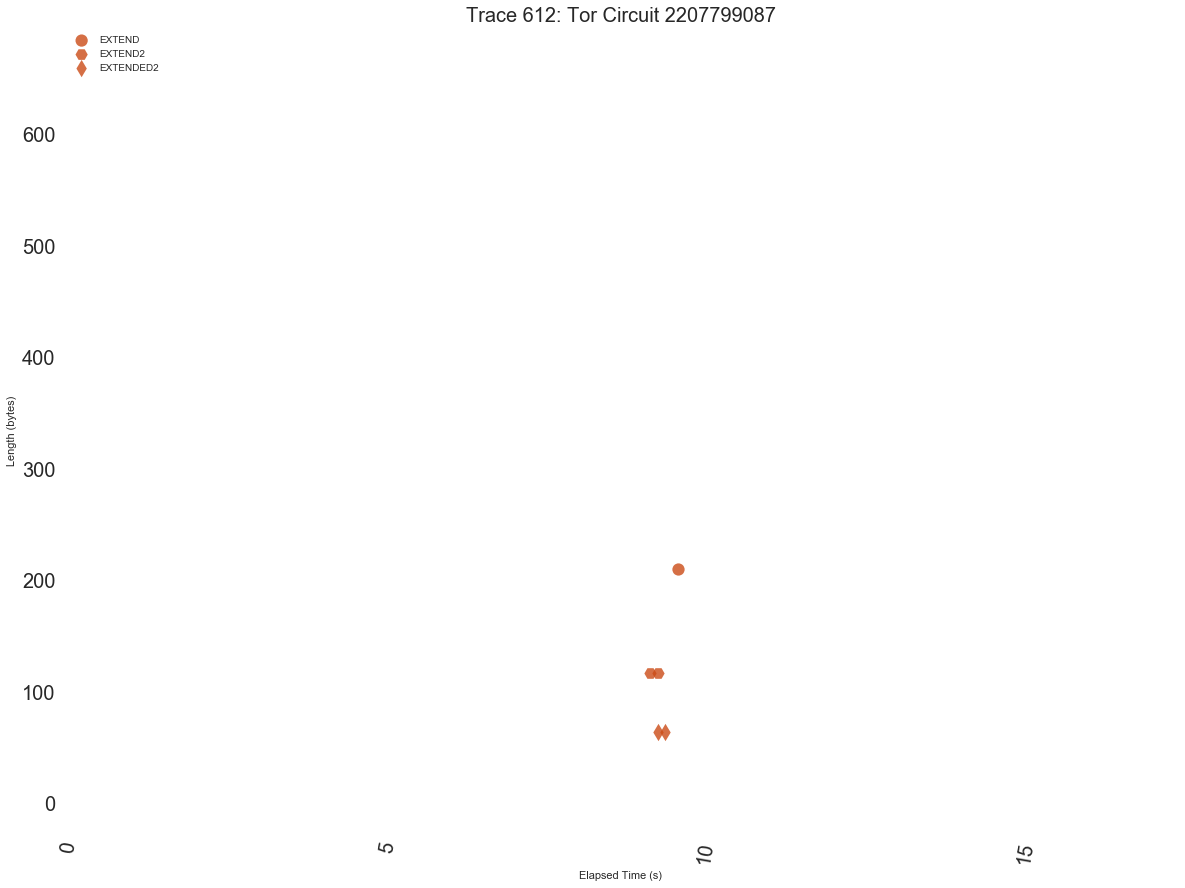

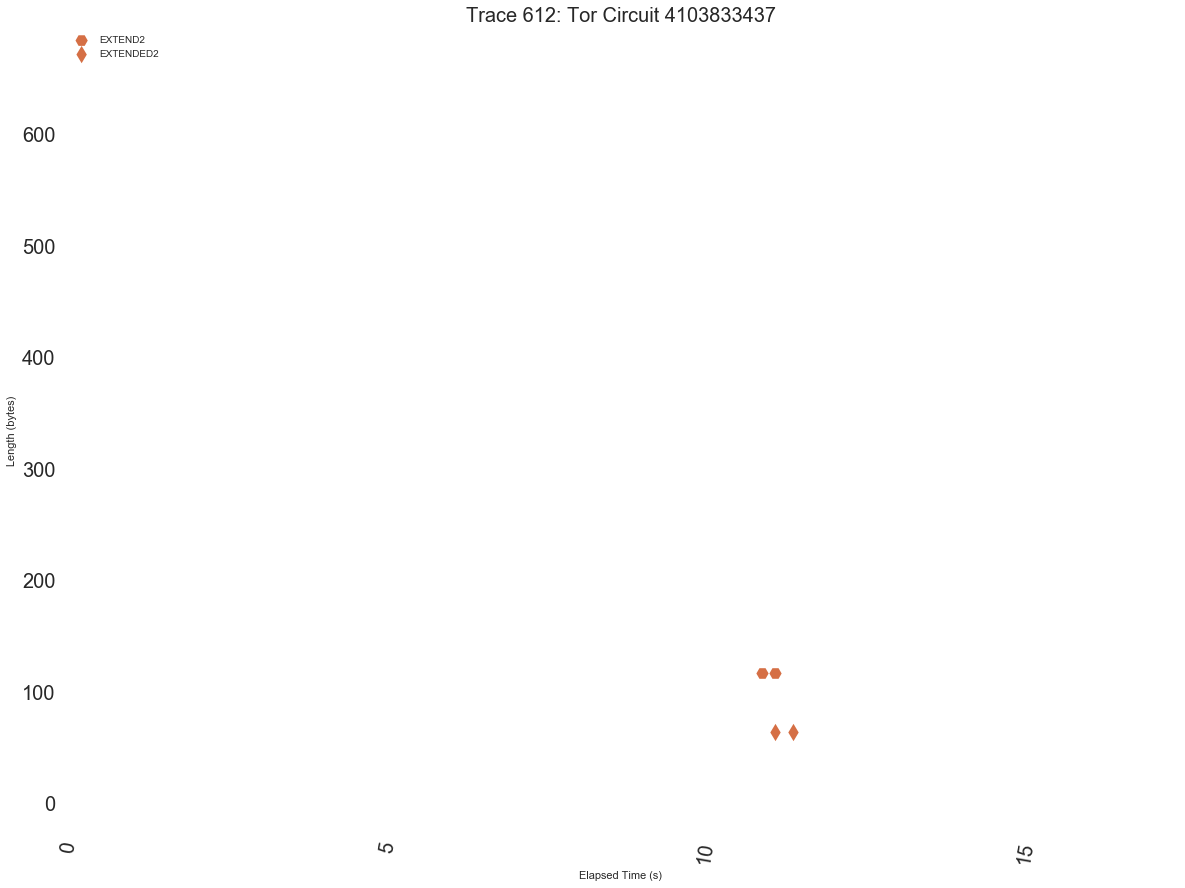

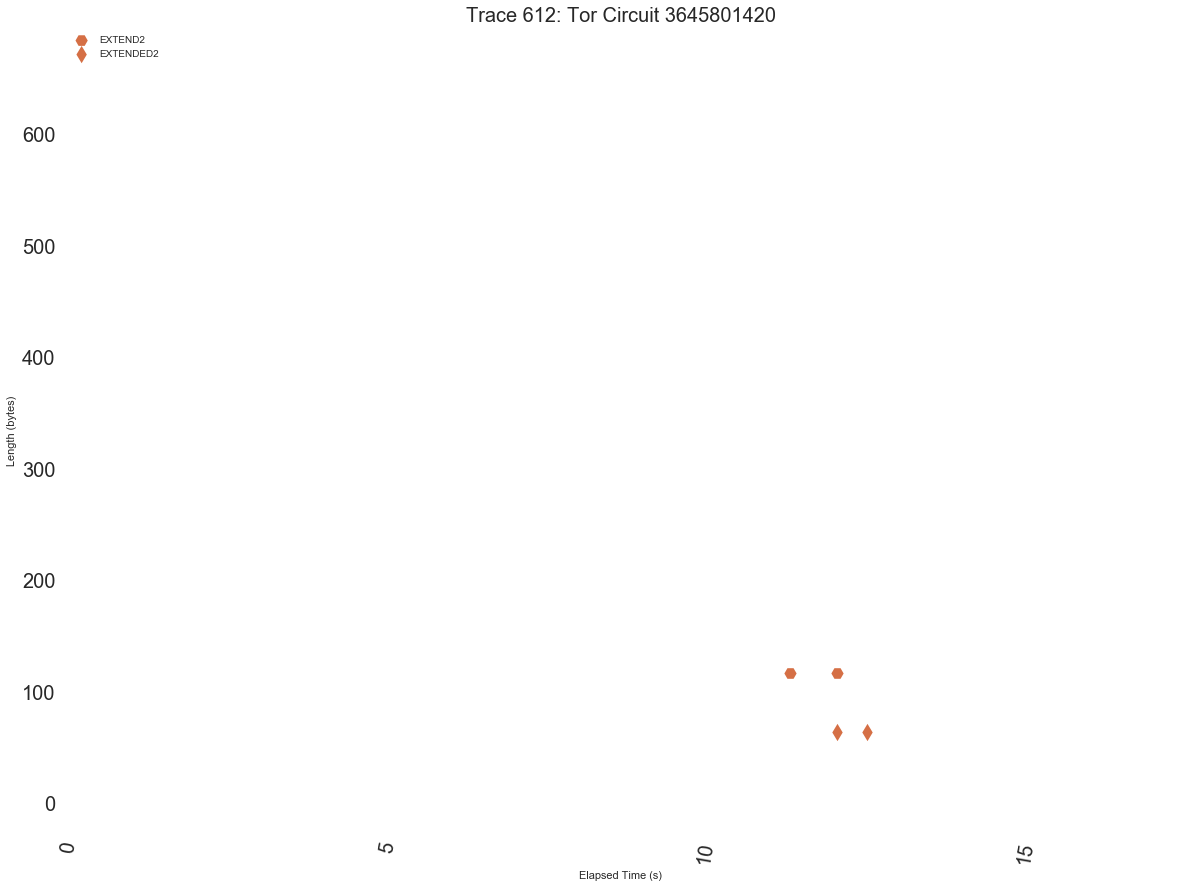

In [7]:
create_by_circuit(df, titlestr="612")

Now we are in a position to answer why there are multiple rendezvous circuits per trace. In the description that follows, Alice is the client and Bob is the Onion service. 

RELAY_COMMAND_INTRODUCE1 cells are sent by Alice once she has built a circuit to one of Bob's introduction points in order to set up a rendezvous (Section 1.8, [0]). 

In our rendezvous circuits above, we can see that there is a really long (~5-10s) delay between RELAY_COMMAND_RENDEZVOUS_ESTABLISHED and RELAY_COMMAND_RENDEZVOUS2 and the beginning (via RELAY_COMMAND_BEGIN) of the TCP stream (See figure: 'Trace 612: Tor Circuit 3541402958'). This means that Alice cannot complete the handshake:

>   When Alice's OP receives a RELAY_COMMAND_RENDEZVOUS2 cell on a circuit which
>   has sent a RELAY_COMMAND_ESTABLISH_RENDEZVOUS cell but which has not yet
>   received a reply, it uses g^y and H(g^xy) to complete the handshake 
- Section 1.10, [0]

We can also see that while Alice is sitting around waiting for the handshake to get set up, she is reaching out to other introduction points with RELAY_COMMAND_INTRODUCE1. 

So I suggest that these multiple rendezvous circuits per trace are due to poor network conditions and/or overloading of Bob's Onion service and not due to leakage from circuit to circuit. 

[0] Tor Rendezvous Specification https://gitweb.torproject.org/torspec.git/tree/rend-spec.txt

Sanity check:

In [8]:
query_sanity = """SELECT * FROM raw.frontpage_traces
WHERE circuit=3541402958
ORDER BY t_trace;"""
df = pd.read_sql(query_sanity, engine)

In [9]:
df

,cellid,exampleid,ingoing,circuit,stream,command,length,t_trace
0,263215,612,False,3541402958,0,EXTEND2(14),119,1.466926e+09
1,263219,612,True,3541402958,0,EXTENDED2(15),66,1.466926e+09
2,263220,612,False,3541402958,0,EXTEND2(14),119,1.466926e+09
3,263222,612,True,3541402958,0,EXTENDED2(15),66,1.466926e+09
4,263223,612,False,3541402958,0,ESTABLISH_RENDEZVOUS(33),20,1.466926e+09
5,263224,612,True,3541402958,0,RENDEZVOUS_ESTABLISHED(39),0,1.466926e+09
6,263280,612,True,3541402958,0,RENDEZVOUS2(37),148,1.466926e+09
7,263281,612,False,3541402958,37117,BEGIN(1),4,1.466926e+09
8,263282,612,False,3541402958,37117,DATA(2),289,1.466926e+09
9,263288,612,True,3541402958,37117,CONNECTED(4),0,1.466926e+09


As expected, this circuit only appears in example 612.

# Let's check another trace

And see if it looks like a similar situation.

In [10]:
query_multiple_rend = """SELECT * FROM raw.frontpage_traces
WHERE exampleid=697
ORDER BY t_trace;"""
df = pd.read_sql(query_multiple_rend, engine)

In [13]:
df

,cellid,exampleid,ingoing,circuit,stream,command,length,t_trace,Elapsed Time
0,340944,697,False,3637234467,0,EXTEND2(14),119,1.466924e+09,0.000000
1,340945,697,True,3637234467,0,EXTENDED2(15),66,1.466924e+09,0.123538
2,340946,697,False,3637234467,0,EXTEND2(14),119,1.466924e+09,0.124811
3,340947,697,False,4171497315,0,EXTEND2(14),119,1.466924e+09,0.185929
4,340948,697,True,3637234467,0,EXTENDED2(15),66,1.466924e+09,0.329293
5,340949,697,False,3637234467,0,EXTEND2(14),119,1.466924e+09,0.332953
6,340950,697,True,4171497315,0,EXTENDED2(15),66,1.466924e+09,0.337125
7,340951,697,False,4171497315,0,EXTEND2(14),119,1.466924e+09,0.338184
8,340952,697,True,4171497315,0,EXTENDED2(15),66,1.466924e+09,0.615008
9,340953,697,True,3637234467,0,EXTENDED2(15),66,1.466924e+09,0.635276


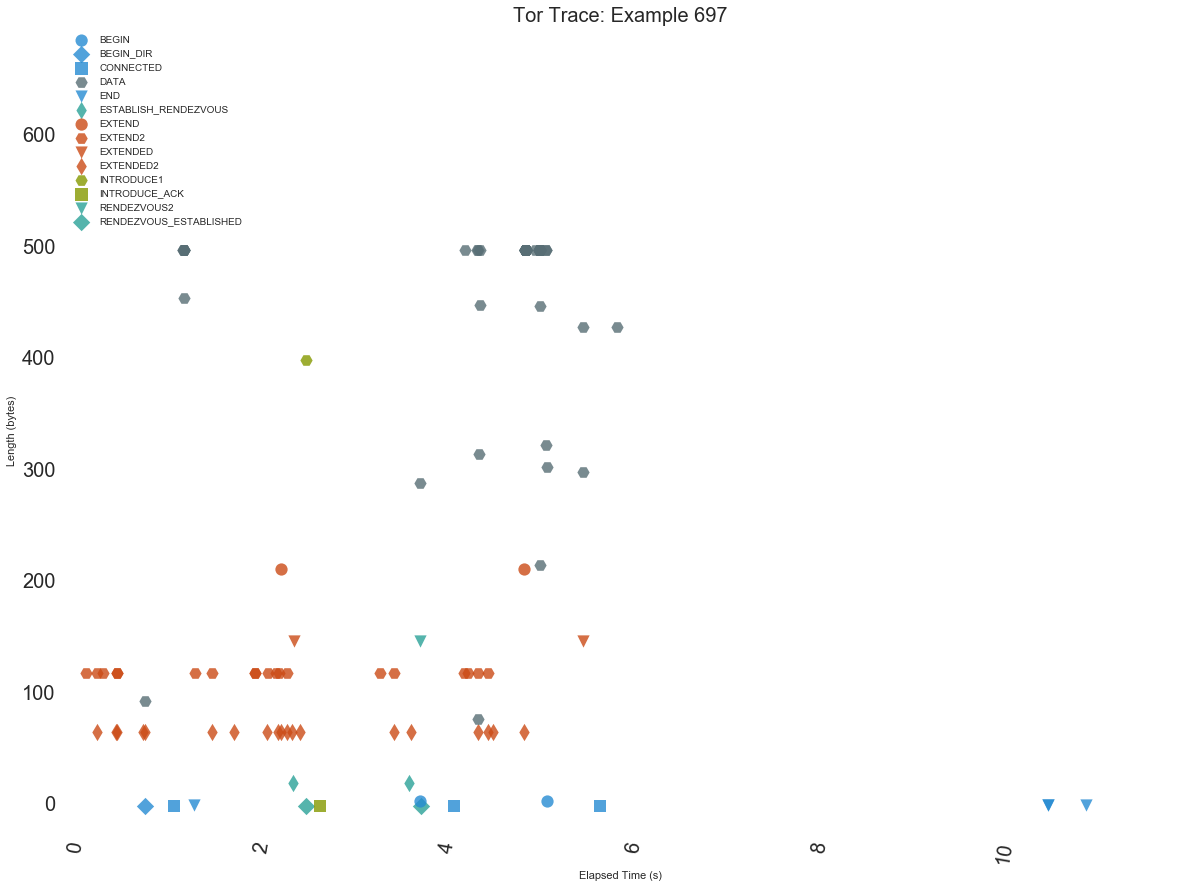

In [12]:
create_single(df, titlestr="Tor Trace: Example 697")

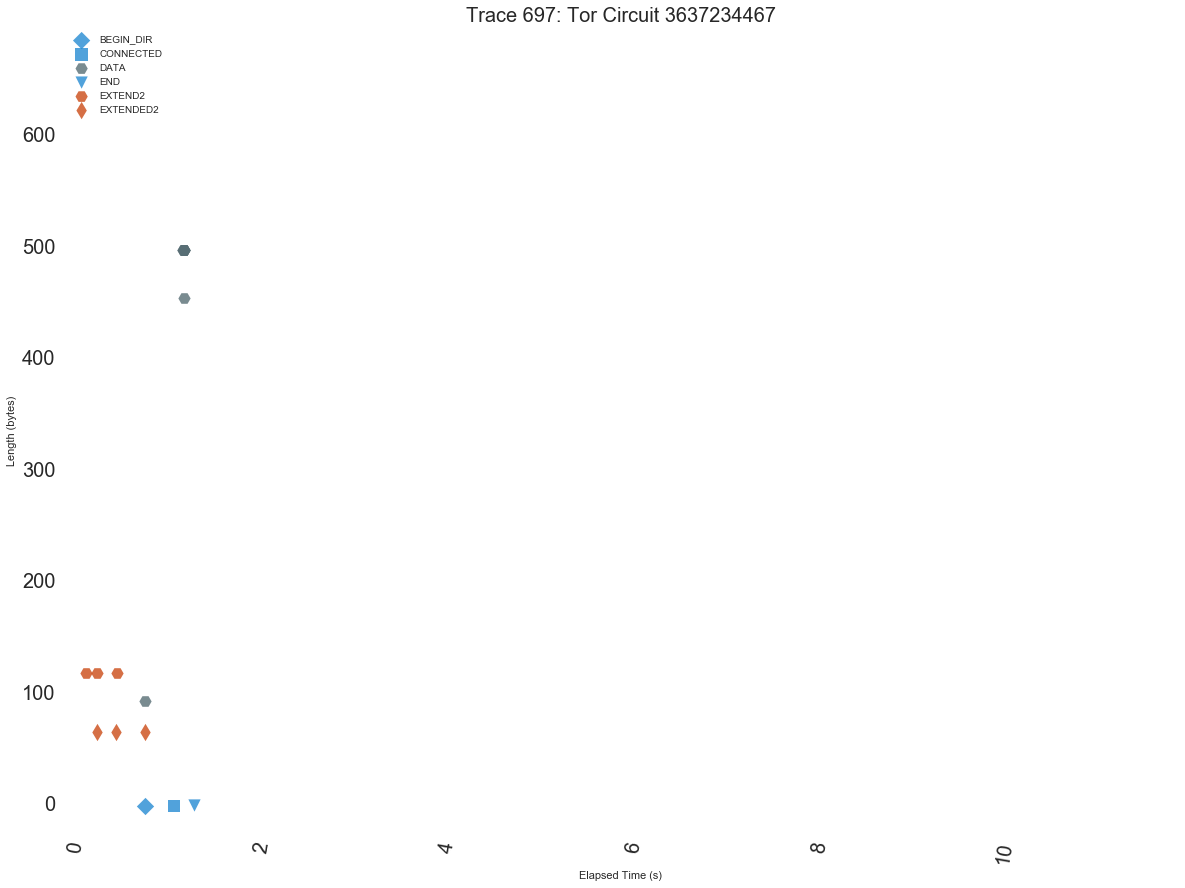

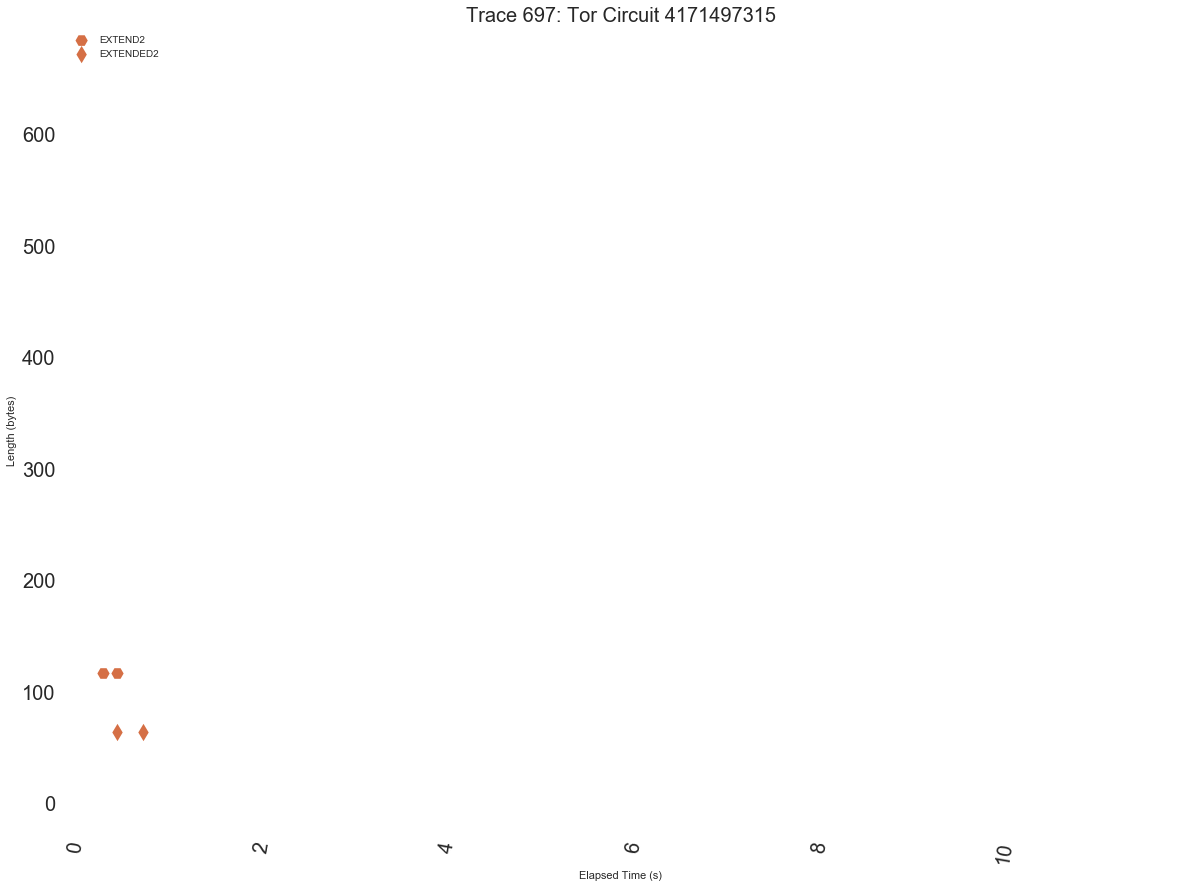

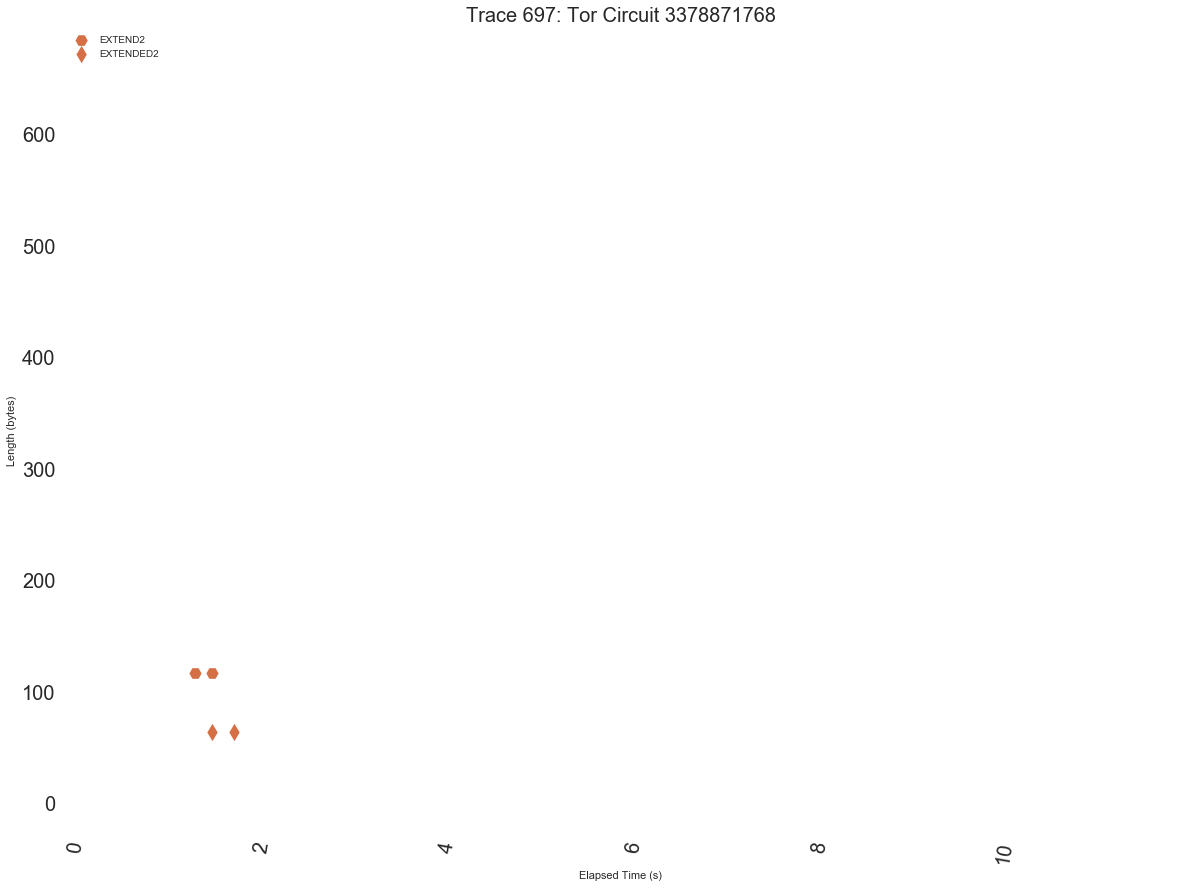

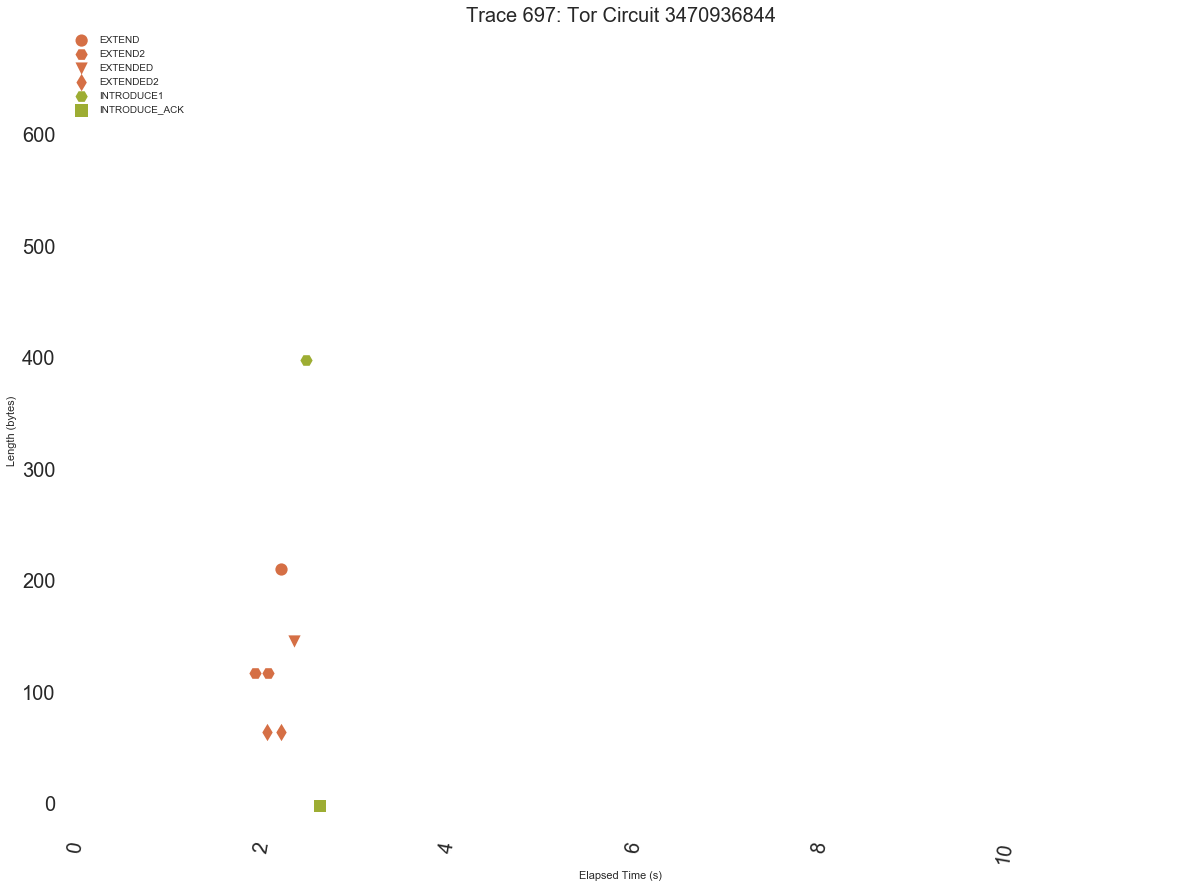

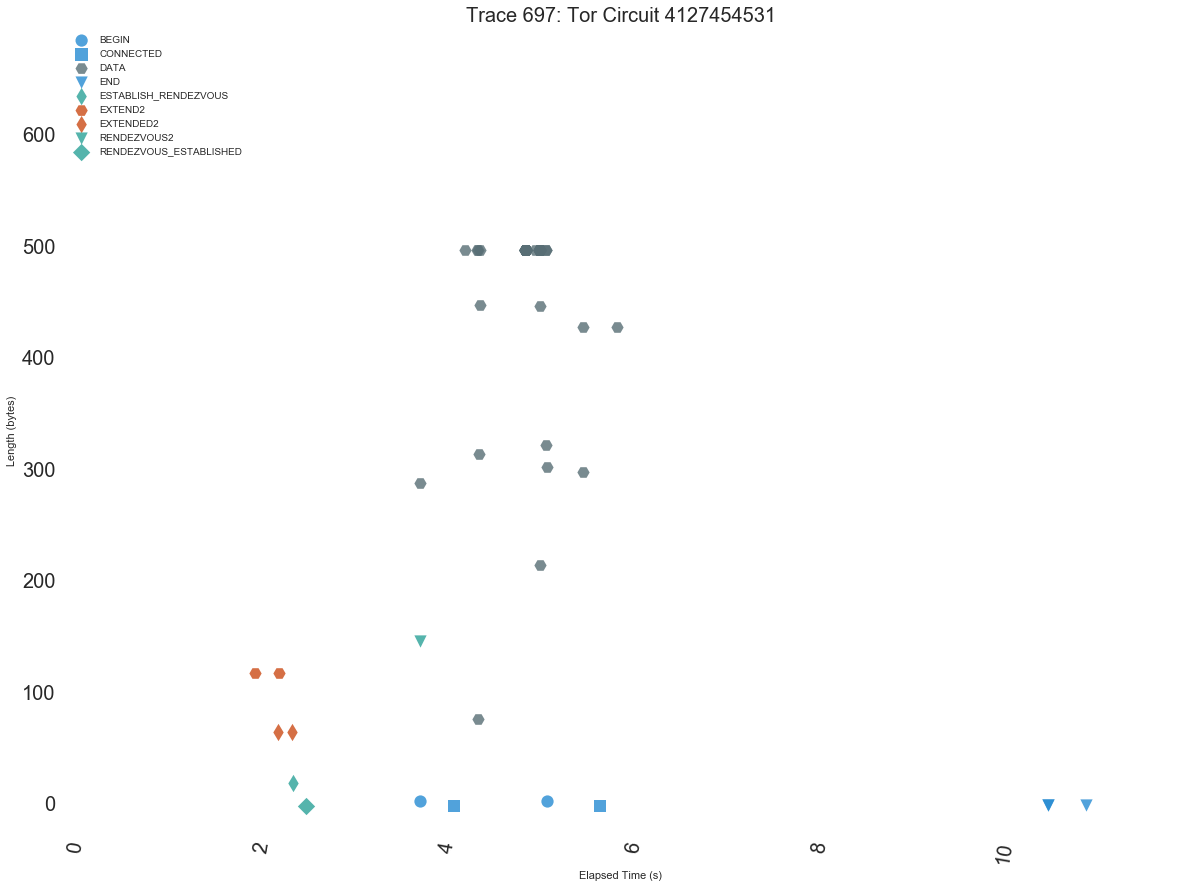

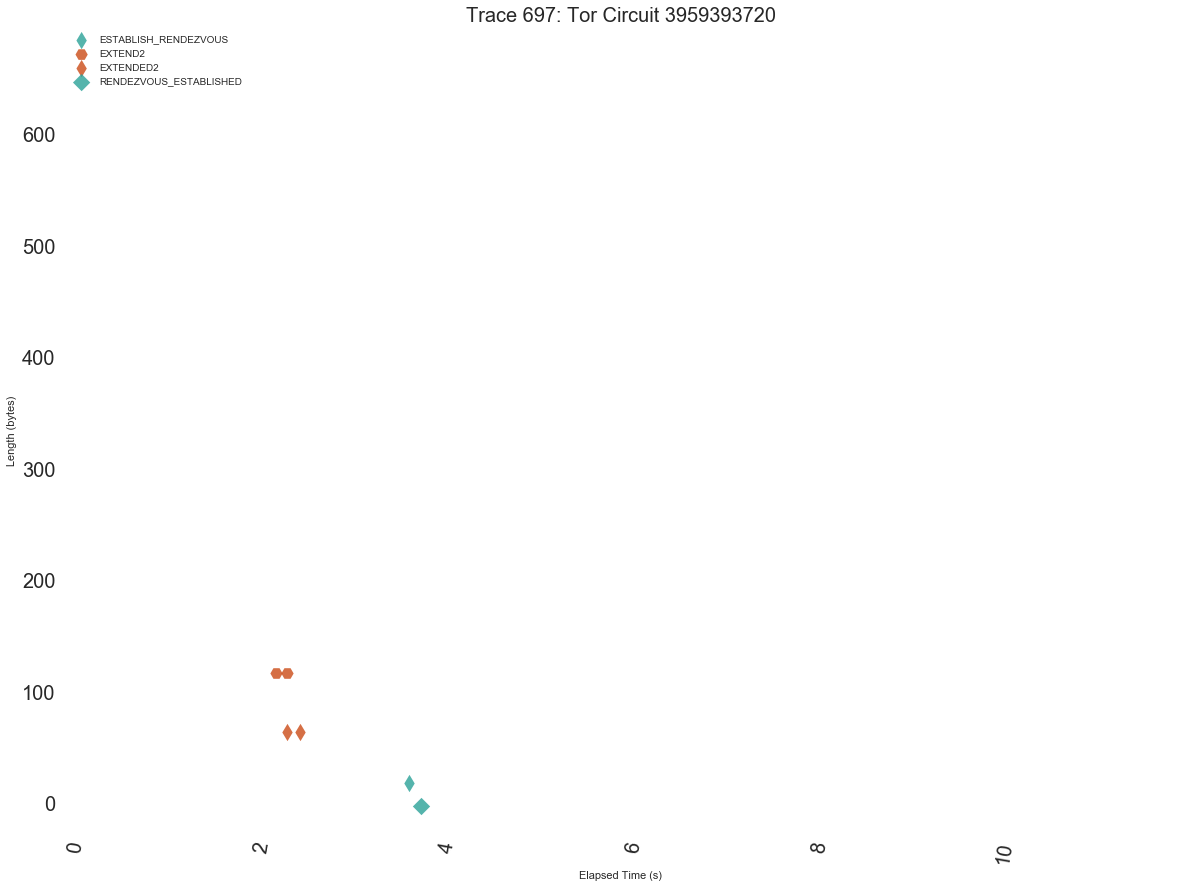

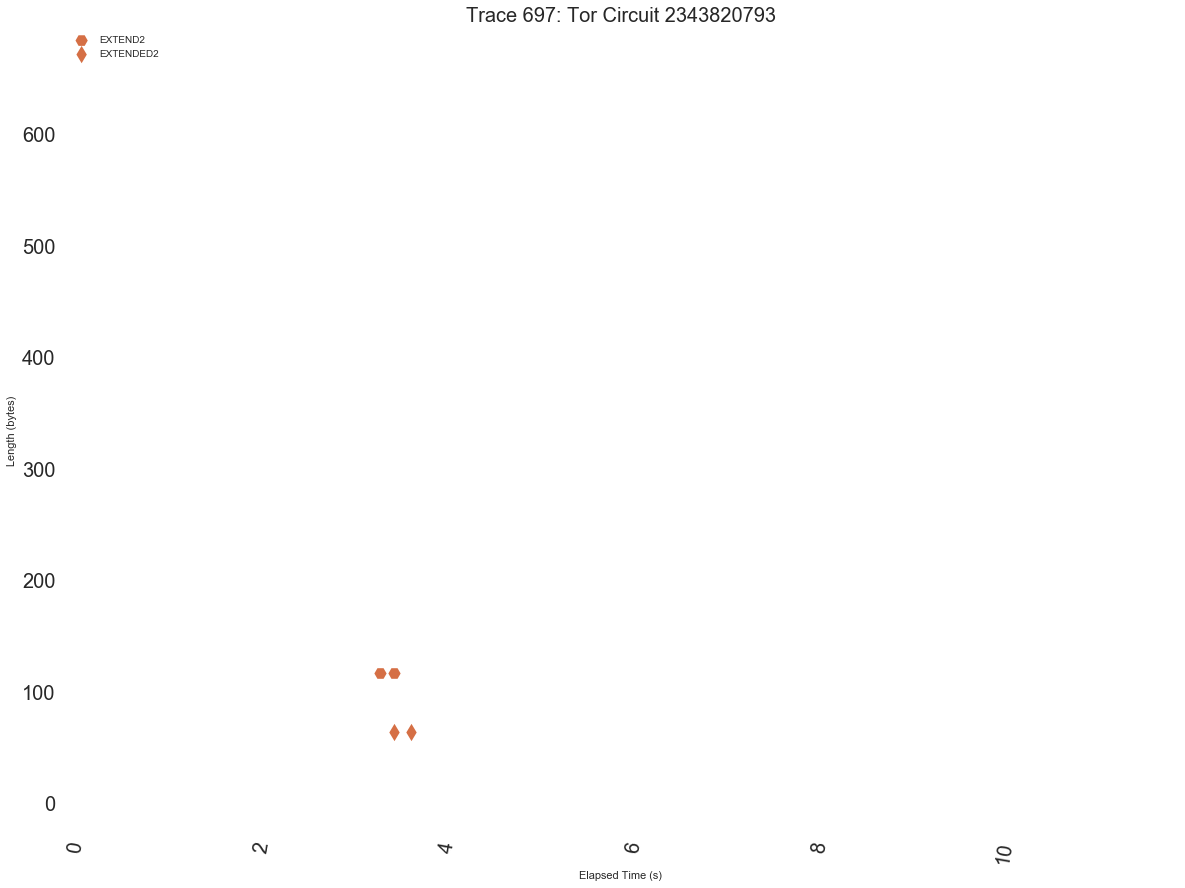

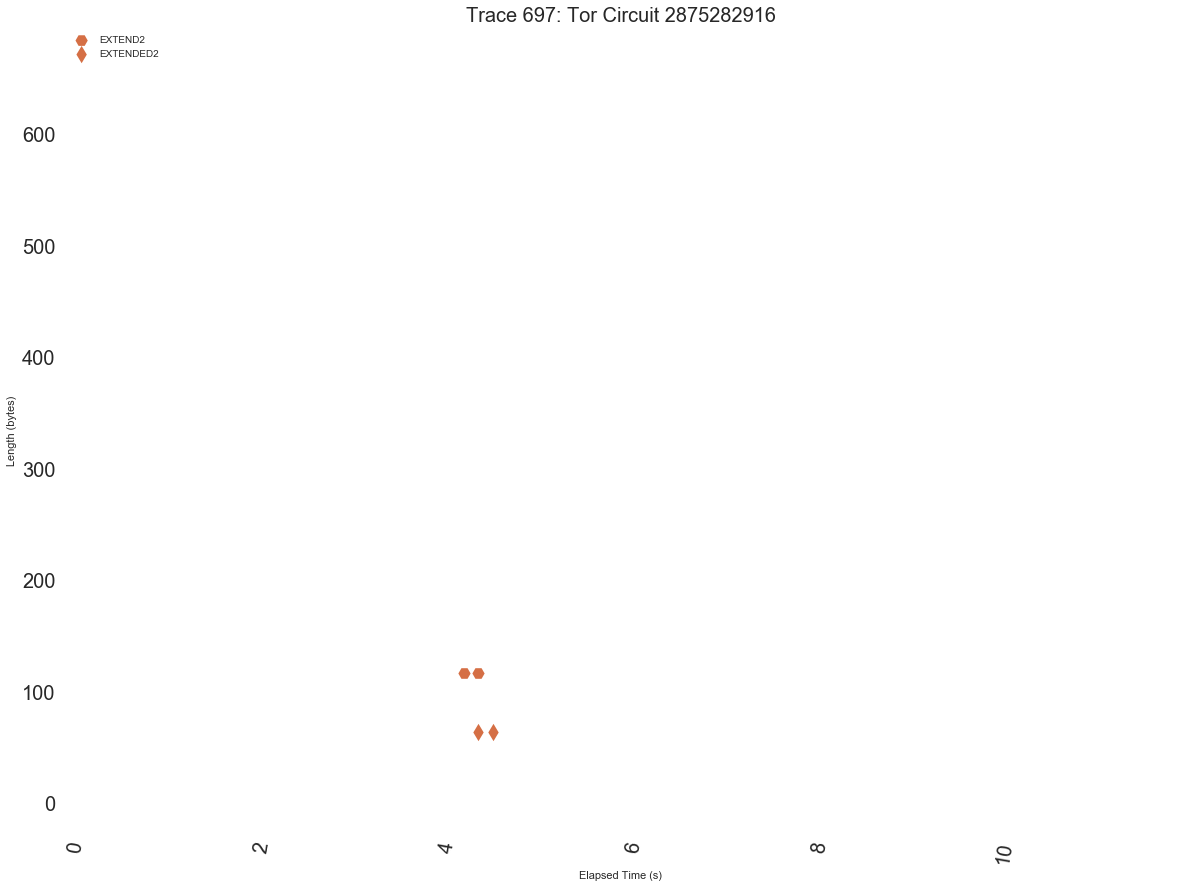

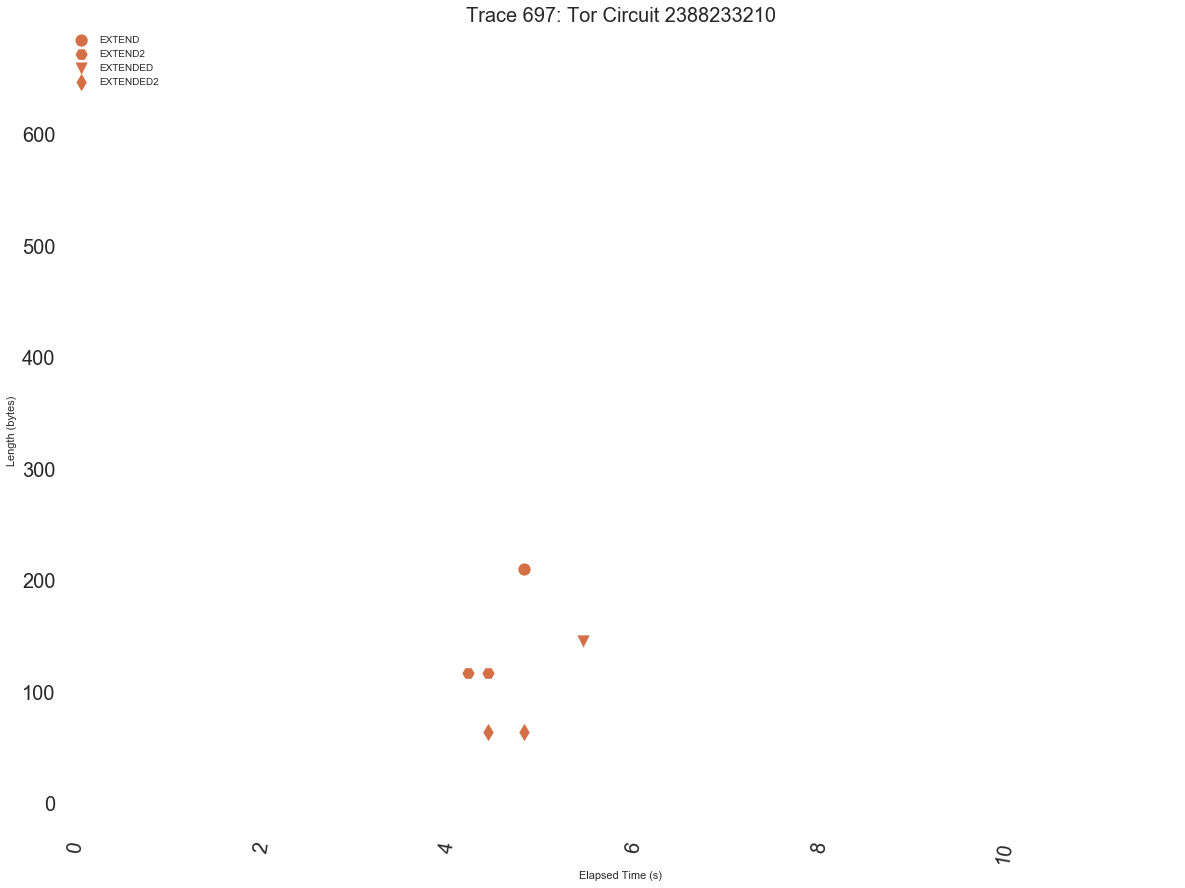

In [16]:
create_by_circuit(df, titlestr="697")

In this trace, it looks like Alice is sitting around waiting for RELAY_COMMAND_RENDEZVOUS2 and so builds another circuit to the RP.

In [30]:
query_sanity = """SELECT * FROM raw.frontpage_traces
WHERE circuit=3959393720
ORDER BY t_trace;"""
df = pd.read_sql(query_sanity, engine)
df['exampleid'].unique()

array([697])

In [29]:
query_sanity = """SELECT * FROM raw.frontpage_traces
WHERE circuit=4127454531
ORDER BY t_trace;"""
df = pd.read_sql(query_sanity, engine)
df['exampleid'].unique()

array([697])

# Last one

In [21]:
query_multiple_rend = """SELECT * FROM raw.frontpage_traces
WHERE exampleid=602
ORDER BY t_trace;"""
df = pd.read_sql(query_multiple_rend, engine)

In [25]:
df

,cellid,exampleid,ingoing,circuit,stream,command,length,t_trace
0,259356,602,False,2997788449,0,EXTEND2(14),119,1.466926e+09
1,259357,602,False,2769367097,0,EXTEND2(14),119,1.466926e+09
2,259358,602,True,2997788449,0,EXTENDED2(15),66,1.466926e+09
3,259359,602,False,2997788449,0,EXTEND2(14),119,1.466926e+09
4,259360,602,True,2997788449,0,EXTENDED2(15),66,1.466926e+09
5,259361,602,False,2997788449,0,EXTEND2(14),119,1.466926e+09
6,259362,602,True,2769367097,0,EXTENDED2(15),66,1.466926e+09
7,259363,602,False,2769367097,0,EXTEND2(14),119,1.466926e+09
8,259364,602,True,2997788449,0,EXTENDED2(15),66,1.466926e+09
9,259365,602,False,2997788449,5255,BEGIN_DIR(13),0,1.466926e+09


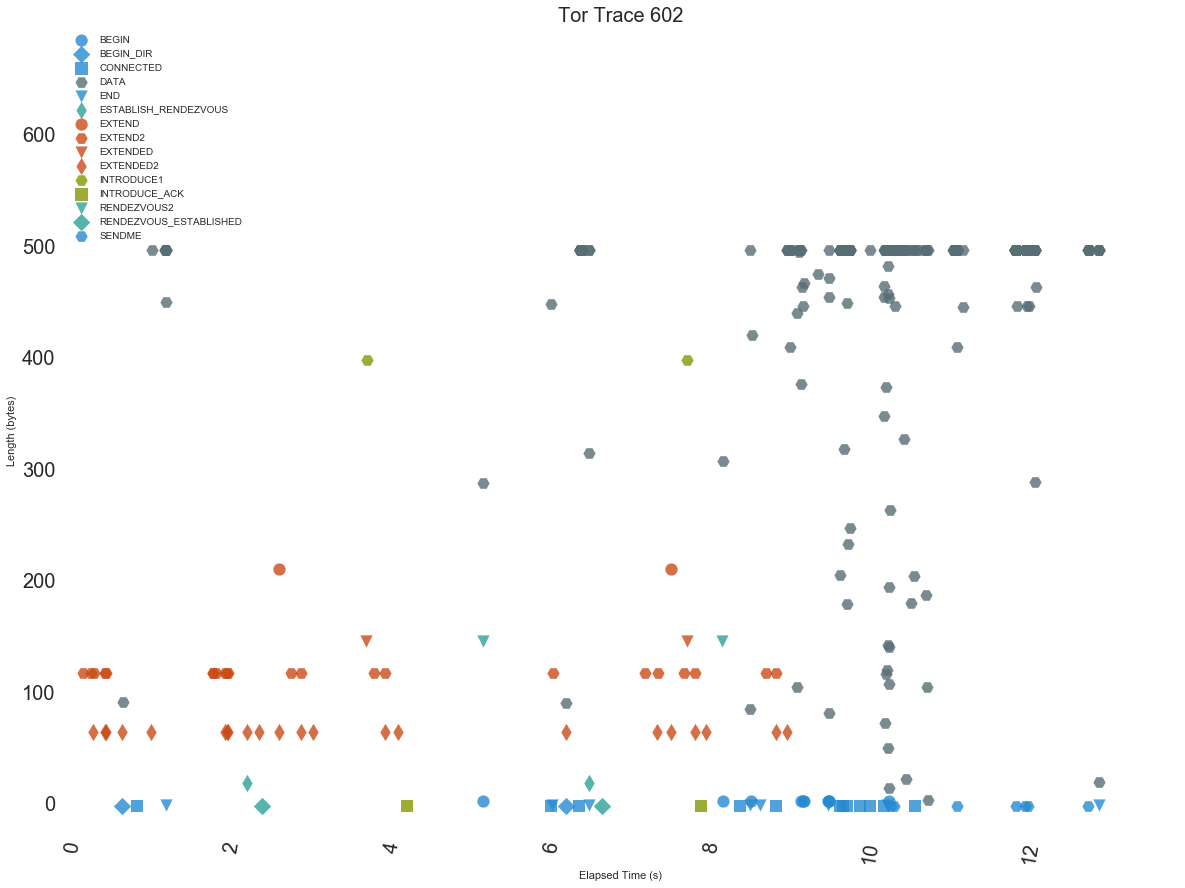

In [26]:
create_single(df, titlestr='Tor Trace 602')

Again, here it takes forever to get back RELAY_COMMAND_RENDEZVOUS2 and there is some additional circuit building to other introduction points in the meantime. 

# Are these rendezvous circuits usually due to network conditions?

We can measure this by looking to see if there is a long delay between RELAY_COMMAND_RENDEZVOUS_ESTABLISHED and RELAY_COMMAND_RENDEZVOUS2. 

Let's again grab all the rendezvous-related cells for the examples with multiple rendezvous circuits:

In [19]:
query_multiple_rend = """SELECT exampleid, circuit, command, t_trace
FROM raw.frontpage_traces
WHERE exampleid in 
  (SELECT exampleid 
   FROM 
    (SELECT exampleid, count(exampleid) 
     FROM raw.frontpage_traces
     WHERE command 
     LIKE 'RENDEZVOUS_ESTABLISHED%%'
     GROUP BY exampleid) multiplerendezvous
   WHERE multiplerendezvous.count > 1)
AND command 
LIKE 'RENDEZVOUS%%'"""
df_multiple_rend_circ = pd.read_sql(query_multiple_rend, engine)

Let's look at the distribution of $\Delta (t_{RENDEZVOUS\_ESTABLISHED} - t_{RENDEZVOUS2})$. If the dominant reason for multiple rendezvous circuits per trace is due to poor network conditions, I would expect there to be a multi-second delay here. 

In [39]:
df_multiple_rend_circ.circuit.unique()

array([3421636332, 2289766222, 3793350858, 3541402958, 4045483115,
       2507659780, 4010302271, 3310589088, 2780291187, 3611555195,
       2383320362, 2291547361, 4140049835, 2998476289, 3275375065,
       3710925699, 2657721727, 2195714205, 4071745032, 2248156425,
       3665415218, 2449892369, 3193579490, 2902842028, 3427834677,
       3470760549, 2684185757, 2999459367, 3279975662, 3033800147,
       3988786193, 3001762824, 4142331568, 4131150846, 4082406337,
       2974251703, 3480889116, 3548293555, 4015791421, 3351664688,
       4127454531, 3959393720, 2323346347, 2152326255, 3287363765,
       3460280105, 3471404018, 3598699184, 4253740126, 3822982894,
       3101578847, 3601989876, 3723278978, 3670761466, 3134699623,
       3361806042, 2795628291, 3073513261, 3759909773, 2191375860,
       3315177467, 2891348992, 4086874155, 3965920949, 3340472886,
       3604264151, 3685898757, 3347796115, 4218160749, 3321081490,
       3287013424, 3016303672, 3007999330, 3956655022, 3118419

In [41]:
df_multiple_rend_circ[df_multiple_rend_circ['circuit'] == 2289766222]

,exampleid,circuit,command,t_trace
2,602,2289766222,RENDEZVOUS_ESTABLISHED(39),1.466926e+09
3,602,2289766222,RENDEZVOUS2(37),1.466926e+09


In [71]:
import numpy as np

# Going to write this out even though it's not the
# most efficient thing in the world :-)

d_time = []

for each_circuit in df_multiple_rend_circ.circuit.unique():
    # Pick out the rendezvous cells for this circuit
    cells_this_circuit = df_multiple_rend_circ[df_multiple_rend_circ['circuit'] == each_circuit]
    
    # Sort them by time
    cells_this_circuit.sort_values('t_trace', axis=0, ascending=True, inplace=True)
    
    # Check number of commands
    if len(cells_this_circuit) == 1:

        # Check order is what we expect
        if cells_this_circuit.command.iloc[0] != 'RENDEZVOUS_ESTABLISHED(39)':
            print('Unexpected command order')
        else:
            # Never got back RENDEZVOUS2!
            d_time.append(-5)
        
    elif len(cells_this_circuit) > 1 and len(cells_this_circuit) < 2:
        # Check order is what we expect
        if cells_this_circuit.command.iloc[0] != 'RENDEZVOUS_ESTABLISHED(39)':
            print('Unexpected command order')
        else:
            d_time.append(cells_this_circuit.t_trace.iloc[1] - 
                          cells_this_circuit.t_trace.iloc[0])

    elif len(cells_this_circuit) > 2:
        print('More cells than expected!')
        pdb.set_trace()

In [63]:
df_deltat = pd.DataFrame({'delta_t': d_time})

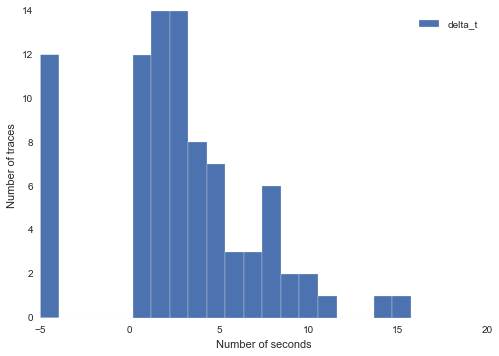

In [64]:
ax = df_deltat.plot(kind='hist', bins=20)
ax.set_xlabel('Number of seconds')
ax.set_ylabel('Number of traces')
ax.grid(False)
ax.set_frame_on(False)

In [68]:
df_formean = df_deltat[df_deltat > 0]

In [69]:
df_formean.dropna().mean()

delta_t    4.08476
dtype: float64

In [70]:
df_formean.dropna().median()

delta_t    3.047063
dtype: float64